In [2]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import pandas_ta as ta

nifty_data = pd.read_csv("nifty_data.csv")

nifty_data['Date'] = pd.to_datetime(nifty_data['Date'], format="%Y-%m-%d") 
nifty_data.set_index('Date', inplace=True)

nifty_data['SMA_50'] = nifty_data['Close'].rolling(window=50).mean()
nifty_data['SMA_200'] = nifty_data['Close'].rolling(window=200).mean()

nifty_data['EMA_12'] = nifty_data['Close'].ewm(span=12, adjust=False).mean()
nifty_data['EMA_26'] = nifty_data['Close'].ewm(span=26, adjust=False).mean()

nifty_data.ta.macd(close = 'Close', fast=12, slow=26, signal=9, append=True)

nifty_data.ta.rsi(close='Close', length=14, append=True)

nifty_data = nifty_data.iloc[200:]

In [4]:
print(nifty_data.head())

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2014-04-07  6694.250000  6725.149902  6650.399902  6695.049805  6695.049805   
2014-04-09  6722.000000  6808.700195  6705.100098  6796.200195  6796.200195   
2014-04-10  6803.049805  6819.049805  6777.299805  6796.399902  6796.399902   
2014-04-11  6758.350098  6789.350098  6743.149902  6776.299805  6776.299805   
2014-04-15  6792.700195  6813.399902  6711.750000  6733.100098  6733.100098   

            Volume       SMA_50      SMA_200       EMA_12       EMA_26  \
Date                                                                     
2014-04-07  133900  6334.652012  6053.040005  6656.367989  6546.747709   
2014-04-09  169800  6343.663018  6057.979006  6677.880636  6565.225671   
2014-04-10  191100  6354.256016  6062.710757  6696.114370  6582.349688   
2014-04-11  140700  6367.065010  6067.524255  6708.450590  6596.716363   
20

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

In [6]:
X_nifty = nifty_data[['Close', 'SMA_50', 'SMA_200', 'RSI_14', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'EMA_12', 'EMA_26']]
y_nifty = nifty_data['Close']

X_train_nifty, X_test_nifty, y_train_nifty, y_test_nifty = train_test_split(X_nifty, y_nifty, test_size=0.2, shuffle=False)

print("X_train_nifty shape:", X_train_nifty.shape)
print("X_test_nifty_shape:", X_test_nifty.shape)
print("y_train_nifty_shape:", y_test_nifty.shape)
print("y_test_nifty_shape:", y_test_nifty.shape)

X_train_nifty shape: (2018, 9)
X_test_nifty_shape: (505, 9)
y_train_nifty_shape: (505,)
y_test_nifty_shape: (505,)


In [10]:
scaler = MinMaxScaler()
X_train_nifty_scaled = scaler.fit_transform(X_train_nifty)
X_test_nifty_scaled = scaler.transform(X_test_nifty)
X_train_nifty_dropped = X_train_nifty.dropna()
y_train_nifty_dropped = y_train_nifty[X_train_nifty_dropped.index]

In [11]:
lr_model_nifty = LinearRegression()
lr_model_nifty.fit(X_train_nifty_scaled, y_train_nifty)

LinearRegression()

In [12]:
lr_predictions_nifty = lr_model_nifty.predict(X_test_nifty_scaled)

mse_lr_nifty = mean_squared_error(y_test_nifty, lr_predictions_nifty)
mae_lr_nifty = mean_absolute_error(y_test_nifty, lr_predictions_nifty)
print(mse_lr_nifty)
print("\n", mae_lr_nifty)

2.8042241756253135e-24

 6.411487402597276e-13


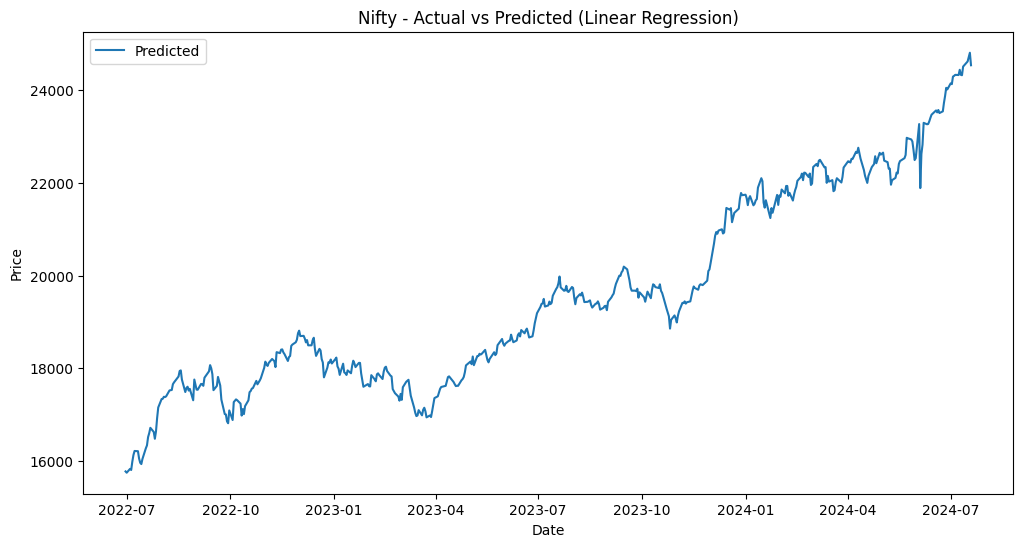

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_nifty.index, lr_predictions_nifty, label='Predicted')
plt.title('Nifty - Actual vs Predicted (Linear Regression)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [14]:
lr_predictions_nifty = pd.Series(lr_predictions_nifty, index=y_test_nifty.index)
print(y_test_nifty.head())
print(lr_predictions_nifty[:5])  # Print first 5 predictions
print(y_test_nifty.shape)
print(lr_predictions_nifty.shape)
print(y_test_nifty.isnull().sum())
print(y_test_nifty.index[:5])
print(lr_predictions_nifty.index[:5])  # Assuming lr_predictions_nifty is a Series with an index

Date
2022-06-30    15780.250000
2022-07-01    15752.049805
2022-07-04    15835.349609
2022-07-05    15810.849609
2022-07-06    15989.799805
Name: Close, dtype: float64
Date
2022-06-30    15780.250000
2022-07-01    15752.049805
2022-07-04    15835.349609
2022-07-05    15810.849609
2022-07-06    15989.799805
dtype: float64
(505,)
(505,)
0
DatetimeIndex(['2022-06-30', '2022-07-01', '2022-07-04', '2022-07-05',
               '2022-07-06'],
              dtype='datetime64[ns]', name='Date', freq=None)
DatetimeIndex(['2022-06-30', '2022-07-01', '2022-07-04', '2022-07-05',
               '2022-07-06'],
              dtype='datetime64[ns]', name='Date', freq=None)


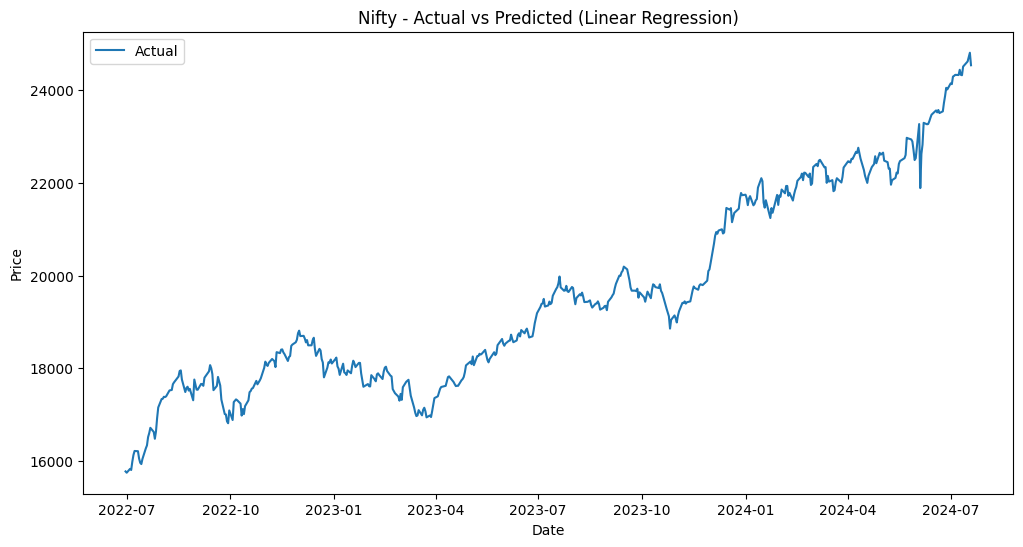

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_nifty.index, y_test_nifty.values, label='Actual')
plt.title('Nifty - Actual vs Predicted (Linear Regression)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

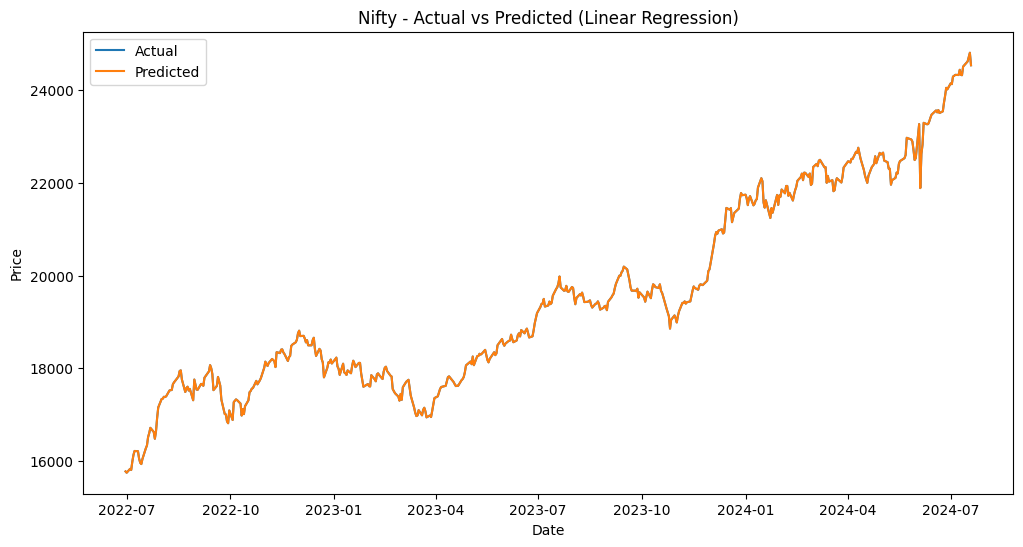

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_nifty.index, y_test_nifty.values, label='Actual')
plt.plot(y_test_nifty.index, lr_predictions_nifty, label='Predicted')
plt.title('Nifty - Actual vs Predicted (Linear Regression)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()